In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm


In [2]:
# Auxiliary functions:
# plot decision surface

def plot_fig(mu, sigma, r = 1000, M = 1000):
    f,ax=plt.subplots(1)
    # prior
    xs=np.linspace(mu[0]-2,mu[1]+2,r)
    zDist_pdf = zDist.pdf(xs)
    ax.plot(xs, zDist_pdf, label = r'$p_{z}$')

    # p_data
    xDist_pdf = xDist.pdf(xs)
    ax.plot(xs, xDist_pdf, label = r'$p_{data}$')
    # distribution of the generator
    g_par = sess.run(g_params)
    g_mu = g_par[1]
    g_sigma = g_par[0]
    gs = norm.pdf(xs,loc=float(g_mu),scale=float(g_sigma))
    ax.plot(xs, gs, label=r'$q_{\theta}$')
    # ylim, legend
    np.max([zDist_pdf,xDist_pdf,gs])
    ax.set_ylim(0,np.max([zDist_pdf,xDist_pdf,gs])+0.2)
    plt.legend()


def adam_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate = 0.001,
        global_step = batch,
        decay_steps = 250,
        decay_rate = 0.95,
        staircase=True
    )
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer


In [9]:
# Class mixture of two normals:

class norm_mix(object):
    def __init__(self, mu, sigma, p = 0.5):
        self.mu = mu
        self.sigma = sigma
        self.p = p
    def rvs(self, N):
        N1 = int(N*self.p)
        samples = np.concatenate([np.random.normal(self.mu[0], self.sigma[0], N1),np.random.normal(self.mu[1], self.sigma[1], N-N1)])
        samples.sort()
        return samples
    def pdf(self, x):
        mix_pdf = self.p* norm.pdf(x,loc=mu[0],scale=sigma[0])+(1-self.p)*norm.pdf(x,loc=mu[1],scale=sigma[1])
        return mix_pdf


In [11]:
#Network hyperpar:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

mu = [1, 3]
sigma=[0.3,0.3]

xDist = norm_mix(mu, sigma)
zDist = norm(0, 1)

# Netork:
hidden_size = 20

# MLP - used for D_pre, D1, D2, G networks
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

#Generator mu+sigma*z
def generator(input, h_dim):
    h0 = linear(input, h_dim, 'g0')
    return h0

def discriminator(input, h_dim, minibatch_layer=False):
    h0 = tf.nn.tanh(linear(input, h_dim * 2, 'd0'))
    h1 = tf.nn.tanh(linear(h0, h_dim * 2, 'd1'))
    # without the minibatch layer, the discriminator needs an additional layer
    # to have enough capacity to separate the two distributions correctly
    if minibatch_layer:
        h2 = minibatch(h1)
    else:
        h2 = tf.nn.tanh(linear(h1, h_dim * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

def minibatch(input, num_kernels=5, kernel_dim=3):
    x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat([input, minibatch_features], 1)


In [12]:
#Pre-train Decision Surface (Discriminator??)
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(None,1))
    train_labels=tf.placeholder(tf.float32,shape=(None,1))
    D = discriminator(input_node, hidden_size)
    loss=tf.reduce_mean(tf.square(D-train_labels)) #Loss is difference bet. GAN output and Gauss Density!

optimizer = adam_optimizer(loss, None)


In [13]:
# BUILD NET
# Now to build the actual generative adversarial network

##Neural Network for the generator:
with tf.variable_scope("Gen"):
    z_node=tf.placeholder(tf.float32, shape=(None,1)) # M standard normals.
    G=generator(z_node,1) # generate normal transformation of Z

##Neural network for the Discriminator:

with tf.variable_scope("Disc") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(None,1)) # input M normally distributed floats
    D1=discriminator(x_node,hidden_size) # output likelihood of being normally distributed
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()#Variables in scope D are reused.
    D2=discriminator(G,hidden_size) #G is the output of a graph in a different scope.


obj_d=tf.reduce_mean(-tf.log(D1)-tf.log(1-D2))
#Loss function 1:
obj_g=tf.reduce_mean(-tf.log(D2))
#Loss function 2:
#obj_g=tf.reduce_mean(-tf.log(D2/(1-D2)))
# copy weights from pre-training over to new D network.
d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')


NameError: name 'grad_optimizer' is not defined

In [14]:
# set up optimizer for G,D
opt_d=adam_optimizer(obj_d, d_params)
opt_g=adam_optimizer(obj_g, g_params) # maximize log(D(G(z)))



In [16]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()


# process multiple points in parallel in a minibatch
M = 1000
lh=np.zeros(1000)
for i in range(1000):
    #d=np.random.normal(mu,sigma,M)
    d=np.reshape(xDist.rvs(M),(M,1)) # Uniform between [-5,5]
    labels=np.reshape(xDist.pdf(d),(M,1))
    lh[i],_=sess.run([loss,optimizer], {input_node: d, train_labels: labels})


0.0 0.925666093826 5.55307626724
0.1 0.866715312004 1.31690776348
0.2 0.953601062298 1.10198998451
0.3 0.956234931946 1.0993168354
0.4 0.954862892628 1.10674107075
0.5 0.957822144032 1.08734381199
0.6 0.955410897732 1.08710753918
0.7 0.957489192486 1.08717215061
0.8 0.955987930298 1.10147321224
0.9 0.955920636654 1.0935459137


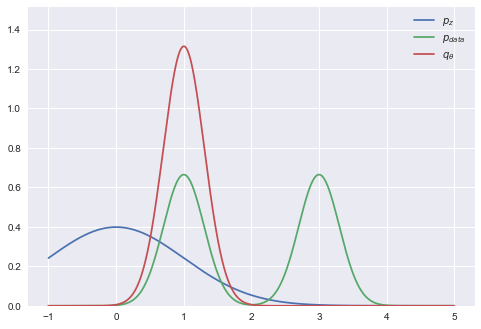

In [17]:
# pre-training Parameters:
weightsD = sess.run(d_pre_params)

for i, v in enumerate(d_params):
    sess.run(v.assign(weightsD[i]))

k=1 #Times we train the discriminator for each run of the generator.
M=1200
TRAIN_ITERS = 12000
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
#histd and histf save the history of the loss for the discriminator and the generator.
for i in range(TRAIN_ITERS):
    for j in range(k):
        x=np.reshape(xDist.rvs(M),(M,1)) # sampled m-batch from p_data
        z = np.reshape(zDist.rvs(M),(M,1)) # sampled m-batch from p_data
        z.sort()
        histd[i],_=sess.run([obj_d, opt_d], {x_node: x, z_node: z})
    z = np.reshape(zDist.rvs(M),(M,1)) # sampled m-batch from p_data
    z.sort()
    histg[i],_=sess.run([obj_g,opt_g], {z_node: z}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS), histd[i], histg[i])

plot_fig(mu, sigma)
plt.show()


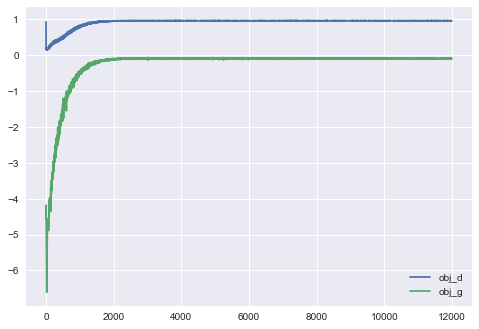

In [18]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()
plt.show()
